# Sistemas de recomendación

## Importar librerías

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

## Carga de datos de MovieLens

In [2]:
df = pd.read_csv("../datasets/ml-100k/u.data.csv", sep = '\t', header = None)

In [3]:
df.columns = ['UserID', 'ItemID', 'Rating',  'TimeStamp']

In [4]:
df.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Análisis exploratorio de los ítems

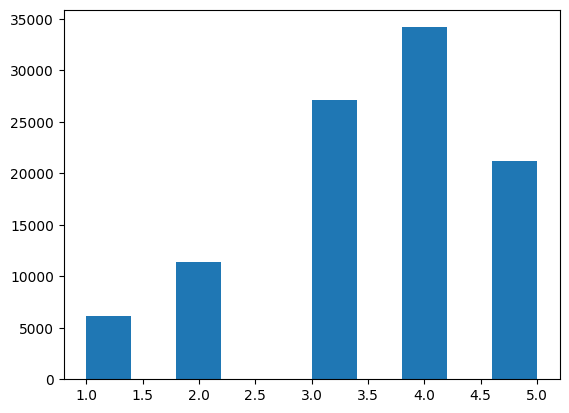

In [5]:
plt.hist(df.Rating)
plt.show()

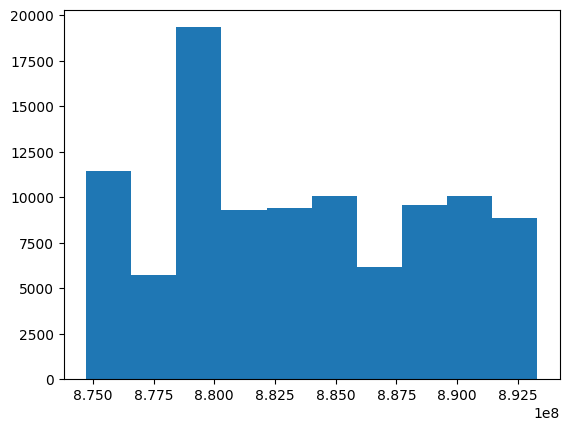

In [6]:
plt.hist(df.TimeStamp)
plt.show()

In [7]:
df.groupby(['Rating'])['UserID'].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

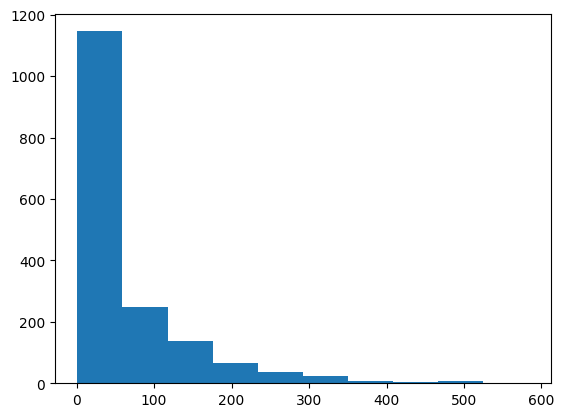

In [8]:
plt.hist(df.groupby(['ItemID'])['ItemID'].count())
plt.show()

## Representación en forma matricial

In [9]:
n_users = df.UserID.unique().shape[0]
n_items = df.ItemID.unique().shape[0]

(n_users, n_items)

(943, 1682)

In [10]:
ratings = np.zeros([n_users, n_items])

In [11]:
for row in df.itertuples():
    ratings[row[1] - 1, row[2] - 1] = row[3]

In [12]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /=(ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print('Coeficiente de esparceidad : {:4.2f}%'.format(sparsity))

Coeficiente de esparceidad : 6.30%


## Creación de conjuntos de entrenamiento y validación

In [13]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state = 42)

In [14]:
ratings_train.shape

(660, 1682)

In [15]:
ratings_test.shape

(283, 1682)

## Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre usuarios (coseno cuadrado).
* Predecir la valoración desconocida de un ítem $i$ para un usuario activo $u$ basándonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendar nuevos ítems a usuarios según establecido pasos anteriores.

In [16]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [21]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis = 1)]).T

In [22]:
users_predictions

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [26]:
def get_mse(preds, actuals):
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [27]:
get_mse(users_predictions, ratings_train)

7.878218313143215

In [28]:
get_mse(users_predictions, ratings_test)

8.745164067978985

## Filtro colaborativo basado en los KNN

In [44]:
k = 6

In [45]:
neighbors = NearestNeighbors(n_neighbors = k, metric = 'cosine')

In [46]:
neighbors.fit(ratings_train)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [47]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance = True)

In [48]:
users_predict_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):
    users_predict_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/ np.array([np.abs(top_k_distances[i].T).sum(axis = 0)]).T

In [49]:
get_mse(users_predict_k, ratings_train)

4.305247677720045

In [50]:
get_mse(users_predict_k, ratings_test)

8.846527997745552

## Filtro colaborativo basado en ítems

In [51]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [52]:
neighbors = NearestNeighbors(n_neighbors = n_movies, metric = 'cosine')

In [53]:
neighbors.fit(ratings_train.T)

NearestNeighbors(metric='cosine', n_neighbors=1682)

In [54]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train.T, return_distance = True)

In [56]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis = 1)])

In [57]:
get_mse(item_preds, ratings_train)

11.460962134170675

In [58]:
get_mse(item_preds, ratings_test)

12.127257997874693

In [63]:
movies = pd.read_csv("../datasets/ml-100k/u.item.csv", sep = '|', header = None, encoding = 'latin1')

In [82]:
movies.iloc[120,1]

'Independence Day (ID4) (1996)'

## Filtrado colaborativo basado en KNN 

In [84]:
k = 30
neighbors = NearestNeighbors(n_neighbors = k, metric = 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance = True)

In [85]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i]) / np.array([np.abs(top_k_distances[i]).sum(axis = 0)]).T

KeyboardInterrupt: 

In [ ]:
get_mse(preds, ratings_train.T)

In [ ]:
get_mse(preds, ratings_test.T)